In [ ]:
import random 
import numpy as np
import pandas as pd

random.seed(42)  # don't change this line

In [ ]:
# Load all data tables
df = pd.read_csv('NHANES-diabetes-train.csv')
df_2 = pd.read_csv('NHANES-diabetes-train.csv')
df_3 = pd.read_csv('NHANES-diabetes-train.csv')

# Output debugging info
print(df.shape)
df.head()

(8140, 1812)


,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520,DIABETIC
0,76195,8,2,1,18,NaN,5,7,1.0,217.0,...,NaN,NaN,NaN,NaN,138.0,18.0,NaN,NaN,NaN,0
1,76958,8,2,2,57,NaN,2,2,1.0,NaN,...,NaN,135.0,115.0,67.0,150.0,45.0,NaN,NaN,NaN,0
2,80248,8,2,2,29,NaN,2,2,2.0,NaN,...,NaN,NaN,125.0,NaN,160.0,28.0,NaN,NaN,NaN,0
3,80213,8,2,2,0,5.0,1,1,2.0,6.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,76753,8,2,1,61,NaN,3,3,2.0,NaN,...,NaN,160.0,160.0,69.0,180.0,30.0,NaN,NaN,NaN,0


In [ ]:
# Print information about the dataset
print('Percentage of instances with missing features:')
print(df.isnull().sum(axis=0)/df.shape[0])
print()
print('Class information:')
print(df['DIABETIC'].value_counts())

Percentage of instances with missing features:
SEQN        0.000000
SDDSRVYR    0.000000
RIDSTATR    0.000000
RIAGENDR    0.000000
RIDAGEYR    0.000000
              ...   
WHQ150      0.407371
WHQ030M     0.853563
WHQ500      0.853563
WHQ520      0.853563
DIABETIC    0.000000
Length: 1812, dtype: float64

Class information:
0    7447
1     693
Name: DIABETIC, dtype: int64


In [ ]:
# Trim dataframe
df = df.dropna(axis=1,thresh=7000) # Drop features with too many missing values
dfcorr = df.corr(method='pearson')

# Select features according to correlation
for i in list(dfcorr):
    corrval = dfcorr[i].DIABETIC
    if corrval > -0.2 and corrval < 0.2:
        df = df.drop(columns=[i])

# Manually drop irrelevant features
df = df.drop(columns=list(df.filter(regex='OHX')))
df = df.drop(columns='DIQ010')
df = df.drop(columns='SIAPROXY')

## **Preprocessing**

The first key step in any data modeling task is cleaning your dataset. Explore your dataset and figure out what sort of preprocessing is required. Good preprocessing can make or break your final model. So choose wisely.

Some of the preprocessing steps that you can consider are :


*   One-hot encoding of variables
*   Missing value imputation
*   Removing outliers
*   Converting binary features into 0-1 representation


Feel free to reuse code you've already written in HW 0.






In [ ]:
# Impute missing values
print(df.isnull().sum(axis=0)/df.shape[0])

df.BMXWT.fillna(df.BMXWT.mean(),inplace=True)
df.BMXBMI.fillna(df.BMXBMI.mean(),inplace=True)
df.BMXARMC.fillna(df.BMXARMC.mean(),inplace=True)
df.DIQ050.fillna(df.DIQ050.median(),inplace=True)

# Remove outlier
df.describe()

outlier = []
for i in range(len(df)):
    dfrow = df[i:i+1]
    if dfrow['DLQ050'].values > 2 or dfrow['HUQ010'].values > 5:
        outlier.append(i)

df = df.drop(outlier) 

# Split data
X = df.drop(['DIABETIC'], axis=1)
y = df['DIABETIC']

SDDSRVYR    0.000000
RIDAGEYR    0.000000
DMDHHSZE    0.000000
DMDHRAGE    0.000000
BMXWT       0.044717
BMXBMI      0.107862
BMXARMC     0.084767
DIQ050      0.038698
DLQ050      0.135749
HUQ010      0.000000
DIABETIC    0.000000
dtype: float64


## **Modeling**

In this section, you are tasked with building a Decision Tree classifier to predict whether or not a patient has diabetes. The overall goal of this exercise is to investigate the dataset and develop features that would improve your model performance.

To help with this process, we have provided the structure for two helper functions. These functions will help in tuning your model as well as validating your model's performance.

Complete these two functions.



In [ ]:
def cross_validated_accuracy(DecisionTreeClassifier, X, y, num_trials, num_folds, random_seed):
    random.seed(random_seed)
    """
       Args:
            DecisionTreeClassifier: An Sklearn DecisionTreeClassifier (e.g., created by "tree.DecisionTreeClassifier(criterion='entropy')")
            X: Input features
            y: Labels
            num_trials: Number of trials to run of cross validation
            num_folds: Number of folds (the "k" in "k-folds")
            random_seed: Seed for uniform execution (Do not change this) 

        Returns:
            cvScore: The mean accuracy of the cross-validation experiment

        Notes:
            1. You may NOT use the cross-validation functions provided by Sklearn
    """
    
    
    length = len(X.index)
    testlen = int(length/num_folds)
    accu1 = []
    accu2 = []
    
    for i in range(num_trials):
        # Shuffle the data set for every trial
        indexes = list(X.index)
        random.seed(random_seed)
        random.shuffle(indexes)
        X_shuffle = X.loc[indexes,:]
        y_shuffle = pd.Series(y,index = indexes)
        
        for j in range(num_folds):
            startind = j*testlen
            endind = (j+1)*testlen
            
            # Select training and testing folders
            X_test = X_shuffle[startind:endind]
            y_test = y_shuffle[startind:endind]
            X_train = X_shuffle[0:startind].append(X_shuffle[endind:length])
            y_train = y_shuffle[0:startind].append(y_shuffle[endind:length])
            
            clf = DecisionTreeClassifier.fit(X_train,y_train) 
            
            y_pred = clf.predict(X_test) # Predict on the test folder
            
            accu2.append(1-((y_test != y_pred).sum())/len(y_pred)) # Calculate accuracy
        
        accu1.append(sum(accu2)/len(accu2))
        accu2 = []
    
    cvScore = sum(accu1)/len(accu1)
            
    return cvScore


#accuracy = cross_validated_accuracy(tree.DecisionTreeClassifier(criterion='entropy',ccp_alpha=0.03), X_3, y_3, 10, 10, 42)

In [ ]:
def automatic_dt_pruning(DecisionTreeClassifier, X, y, num_trials, num_folds, random_seed):
    random.seed(random_seed)
    """
      Returns the pruning parameter (i.e., ccp_alpha) with the highest cross-validated accuracy

      Args:
            DecisionTreeClassifier  : An Sklearn DecisionTreeClassifier (e.g., created by "tree.DecisionTreeClassifier(criterion='entropy')")      
            X (Pandas.DataFrame)    : Input Features
            y (Pandas.Series)       : Labels
            num_trials              : Number of trials to run of cross validation
            num_folds               : Number of folds for cross validation (The "k" in "k-folds") 
            random_seed             : Seed for uniform execution (Do not change this)


       Returns:
            ccp_alpha : Tuned pruning paramter with highest cross-validated accuracy

       Notes:
            1. Don't change any other Decision Tree Classifier parameters other than ccp_alpha
            2. Use the cross_validated_accuracy function you implemented to find the cross-validated accuracy

    """
   
    # Set the range for ccp_alpha   
    step = 0.02
    maxccp = 0.4
    num = int(maxccp/step)
    result = []
    
    for i in range(num+1):
        ccp_test = i*step
        DecisionTreeClassifier.set_params(ccp_alpha = ccp_test)
        
        # Call the cross-validate function to compute accuracy
        accu_test = cross_validated_accuracy(DecisionTreeClassifier, X, y, num_trials, num_folds, random_seed)
        result.append([ccp_test, accu_test])
    
    # Find cpp_alpha with highest accuracy
    df = pd.DataFrame(result, columns = ['cppVal', 'Accuracy']) 
    s = df['cppVal'][df.Accuracy == df.Accuracy.max()]
    ccp_alpha = s.mean()
    
    return ccp_alpha


#automatic_dt_pruning(tree.DecisionTreeClassifier(criterion='entropy'), X, y, 5, 5, 42)

## **Tuning and Testing**

With the helper functions and your processed dataset, build a Decision Tree classifier to classify Diabetic patients and tune it to maximize model performance.

Once you are done with your modeling process, test your model on the test dataset and output your predictions in a file titled "hw1_predictions.csv", with one row per prediction.

The cross-validated accuracy is 0.9356703567035674



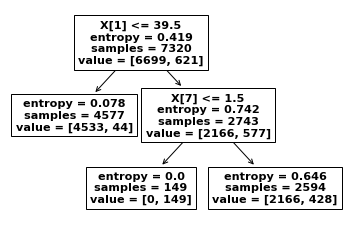

In [ ]:
# Train a decision tree on the data
from sklearn import tree

# Train and prune the decision tree
clf = tree.DecisionTreeClassifier(criterion='entropy')

bestccp = automatic_dt_pruning(clf, X, y, 5, 10, 42)
clf.set_params(ccp_alpha = bestccp)

# Compute the cross-validated accuracy
CV = cross_validated_accuracy(clf, X, y, 10, 10, 42)
print('The cross-validated accuracy is', CV)

# Plot the tree
tree.plot_tree(clf)

print()

In [ ]:
# Predict on test data
X_test = pd.read_csv('hw1-NHANES-diabetes-test-unlabeled.csv')

# Pre-process the test data
X_test = X_test[list(X.columns)]

X_test.BMXWT.fillna(X_test.BMXWT.mean(),inplace=True)
X_test.BMXBMI.fillna(X_test.BMXBMI.mean(),inplace=True)
X_test.BMXARMC.fillna(X_test.BMXARMC.mean(),inplace=True)
X_test.DIQ050.fillna(X_test.DIQ050.median(),inplace=True)
X_test.DLQ050.fillna(X_test.DLQ050.median(),inplace=True)

print(X_test.isnull().sum(axis=0)/df.shape[0])

y_pred = clf.predict(X_test)

SDDSRVYR    0.0
RIDAGEYR    0.0
DMDHHSZE    0.0
DMDHRAGE    0.0
BMXWT       0.0
BMXBMI      0.0
BMXARMC     0.0
DIQ050      0.0
DLQ050      0.0
HUQ010      0.0
dtype: float64


In [ ]:
# Save the predictions
y_data = pd.DataFrame(y_pred)
y_data.describe()
y_data.to_csv('hw1_predictions.csv',index=False)

In [ ]:
# Test on other features

# Pre-process data
df_2 = df_2.dropna(axis=1,thresh=6000) # Drop features with too many missing values
print(df_2.isnull().sum(axis=0)/df.shape[0])

df_2 = df_2.drop(columns='DIQ010')

y_2 = df_2['DIABETIC']
X_2 = df_2.drop(['DIABETIC'], axis=1)

randomfeat = np.random.randint(100,size=20)
X_2 = X_2.iloc[:,randomfeat]
X_2.fillna(0,inplace=True)

# Train a decision tree on the data
from sklearn import tree

# Train and prune the decision tree
clf = tree.DecisionTreeClassifier(criterion='entropy')

bestccp = automatic_dt_pruning(clf, X_2, y_2, 5, 10, 42)
clf.set_params(ccp_alpha = bestccp)

# Compute the cross-validated accuracy
CV = cross_validated_accuracy(clf, X_2, y_2, 10, 10, 42)
print('The cross-validated accuracy is', CV)



SEQN         0.000000
SDDSRVYR     0.000000
RIDSTATR     0.000000
RIAGENDR     0.000000
RIDAGEYR     0.000000
               ...   
SMQ872       0.171646
SMQ874       0.007131
SMQ878       0.007131
SMAQUEX.x    0.003197
DIABETIC     0.000000
Length: 347, dtype: float64
The cross-validated accuracy is 0.9148648648648645


In [ ]:
# Test on other features

df_3 = df_3[['RIDAGEYR', 'BMXWAIST', 'BMXHT',
       'LBXTC', 'BMXLEG', 'BMXWT',
       'BMXBMI', 'RIDRETH1', 'BPQ020',
       'ALQ120Q', 'DMDEDUC2', 'RIAGENDR',
       'INDFMPIR',
       'DIABETIC']]

df_3 = df_3.dropna(axis=0)

y_3 = df_3['DIABETIC']
X_3 = df_3.drop(['DIABETIC'], axis=1)

# Train a decision tree on the data
from sklearn import tree

# Train and prune the decision tree
clf = tree.DecisionTreeClassifier(criterion='entropy')

bestccp = automatic_dt_pruning(clf, X_3, y_3, 5, 10, 42)
clf.set_params(ccp_alpha = bestccp)

# Compute the cross-validated accuracy
CV = cross_validated_accuracy(clf, X_3, y_3, 10, 10, 42)
print('The cross-validated accuracy is', CV)


The cross-validated accuracy is 0.8603333333333334
